In [1]:
%cd ..

/home/eli/AnacondaProjects/ppc_experiments


In [2]:
import argparse
import collections
import numpy as np
import pyro
import torch
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from parse_config import ConfigParser
import trainer.trainer as module_trainer

In [3]:
# pyro.enable_validation(True)
# torch.autograd.set_detect_anomaly(True)

In [4]:
# fix random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

In [5]:
from utils import read_json

config = read_json("experiments/ppc_celeba_config.json")
config = ConfigParser(config)

In [6]:
logger = config.get_logger('train')

# setup data_loader instances
data_loader = config.init_obj('data_loader', module_data)
valid_data_loader = data_loader.split_validation()

# build model architecture, then print to console
model = config.init_obj('arch', module_arch)
logger.info(model)

# get function handles of metrics
metrics = [getattr(module_metric, met) for met in config['metrics']]

# build optimizer.
if "lr_scheduler" in config:
    lr_scheduler = getattr(pyro.optim, config["lr_scheduler"]["type"])
    lr_scheduler = optimizer = lr_scheduler({
        "optimizer": getattr(torch.optim, config["optimizer"]["type"]),
        "optim_args": config["optimizer"]["args"]["optim_args"],
        **config["lr_scheduler"]["args"]
    })
else:
    optimizer = config.init_obj('optimizer', pyro.optim)
    lr_scheduler = None

# build trainer
# kwargs = config['trainer'].pop('args')
trainer = config.init_obj('trainer', module_trainer, model, metrics, optimizer,
                          config=config, data_loader=data_loader,
                          valid_data_loader=valid_data_loader,
                          lr_scheduler=lr_scheduler)

Files already downloaded and verified
CelebAPpc(
  (prior): GaussianPrior()
  (likelihood): ConvolutionalDecoder(
    (linear): Sequential(
      (0): Linear(in_features=40, out_features=256, bias=True)
      (1): SiLU()
    )
    (convs): Sequential(
      (0): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(1, 1))
      (1): SiLU()
      (2): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): SiLU()
      (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): SiLU()
      (6): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): SiLU()
      (8): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
  )
  (graph): PpcGraphicalModel()
)
Trainable parameters: 401347


/home/eli/miniforge3/envs/ppc/lib/python3.11/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(


Initialize particles: train batch 0
Initialize particles: train batch 1
Initialize particles: train batch 2
Initialize particles: train batch 3
Initialize particles: train batch 4
Initialize particles: train batch 5
Initialize particles: train batch 6
Initialize particles: train batch 7
Initialize particles: train batch 8
Initialize particles: train batch 9
Initialize particles: train batch 10
Initialize particles: train batch 11
Initialize particles: train batch 12
Initialize particles: train batch 13
Initialize particles: train batch 14
Initialize particles: train batch 15
Initialize particles: train batch 16
Initialize particles: train batch 17
Initialize particles: train batch 18
Initialize particles: train batch 19
Initialize particles: train batch 20
Initialize particles: train batch 21
Initialize particles: train batch 22
Initialize particles: train batch 23
Initialize particles: train batch 24
Initialize particles: train batch 25
Initialize particles: train batch 26
Initialize 

In [7]:
logger.info(trainer.config.log_dir)

saved/log/CelebA_Ppc/0502_163622


In [8]:
trainer.train()

Train Epoch: 1 [0/146493 (0%)] Loss: 13375.256836


/home/eli/miniforge3/envs/ppc/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Train Epoch: 1 [32768/146493 (22%)] Loss: 11660.421875
Train Epoch: 1 [65536/146493 (45%)] Loss: 11285.608398
Train Epoch: 1 [98304/146493 (67%)] Loss: 10910.339844
Train Epoch: 1 [131072/146493 (89%)] Loss: 10529.095703
    epoch          : 1
    loss           : 11326.852362738715
    ess            : 2.0004246797826557
    log_marginal   : -11326.852322048611
    val_loss       : 10379.89697265625
    val_ess        : 2.00042462348938
    val_log_marginal: -10379.89697265625
Train Epoch: 2 [0/146493 (0%)] Loss: 10403.169922
Train Epoch: 2 [32768/146493 (22%)] Loss: 10215.528320
Train Epoch: 2 [65536/146493 (45%)] Loss: 9825.557617
Train Epoch: 2 [98304/146493 (67%)] Loss: 9581.957031
Train Epoch: 2 [131072/146493 (89%)] Loss: 9274.656250
    epoch          : 2
    loss           : 9803.589864095053
    ess            : 2.000424651636018
    log_marginal   : -9803.589884440104
    val_loss       : 9102.869140625
    val_ess        : 2.00042462348938
    val_log_marginal: -9102.869384

In [9]:
trainer.model.eval()
trainer.model.cpu()
trainer.cpu()
trainer.train_particles.cpu()
trainer.valid_particles.cpu()

ParticleDict(  (z): Parameter containing: [torch.FloatTensor of size 2x16277x40])

In [10]:
trainer.model.graph.clear()
trainer._load_particles(range(trainer.data_loader.batch_size), False)

In [11]:
for site in trainer.model.graph.nodes:
    trainer.model.graph.nodes[site]['is_observed'] = trainer.model.graph.nodes[site]['value'] is not None

In [12]:
import utils

In [13]:
with pyro.plate_stack("forward", (trainer.num_particles, trainer.data_loader.batch_size)):
    model = pyro.condition(trainer.model, data={k: v['value'] for k, v in trainer.model.graph.nodes.items()})
    xs = model()

In [14]:
import matplotlib.pyplot as plt

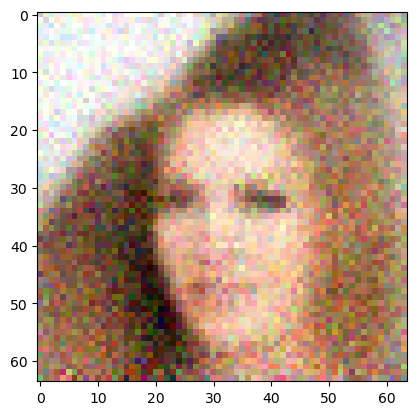

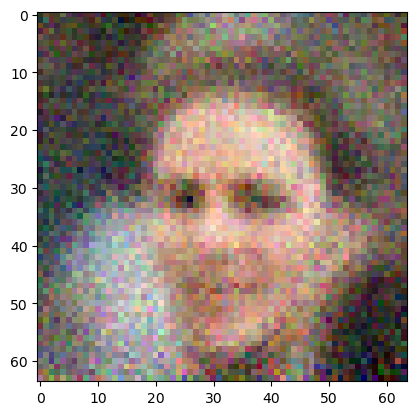

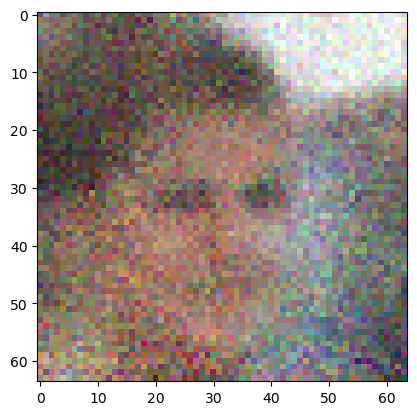

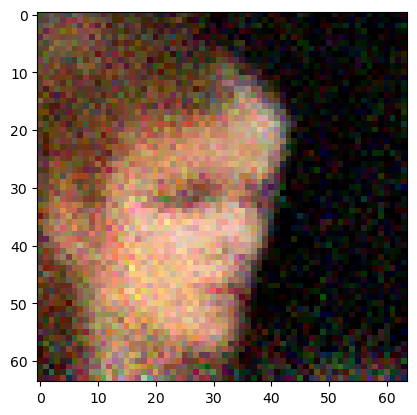

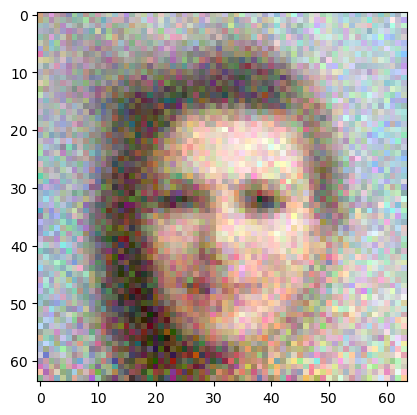

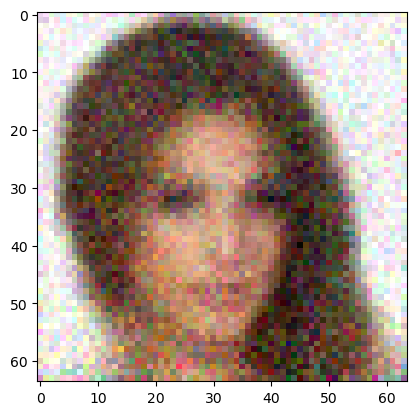

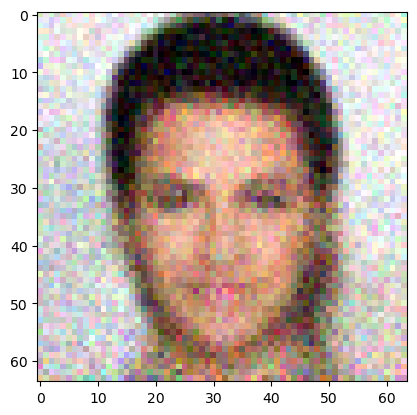

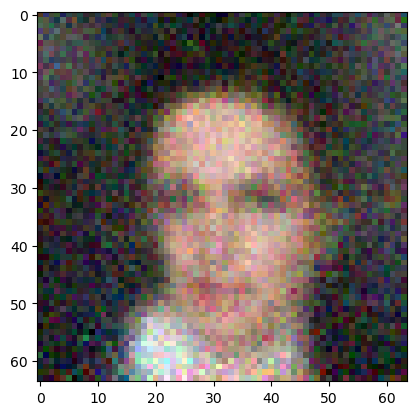

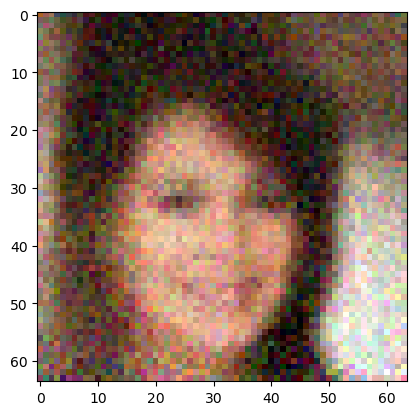

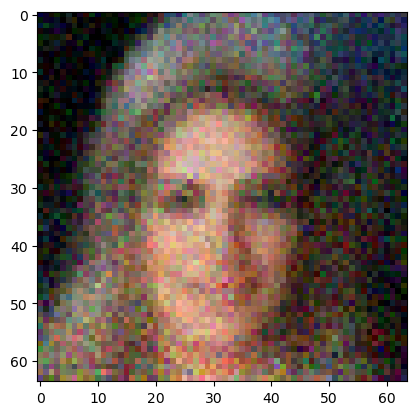

In [24]:
for i in range(10):
    plt.imshow(torch.clamp(xs.mean(dim=0)[i].squeeze(), 0, 1).mT.detach().cpu().transpose(0, -1).numpy())
    plt.show()